In [1]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,classification_report
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_validate,GridSearchCV,RandomizedSearchCV,train_test_split, cross_val_score
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline, FunctionTransformer
import types
import seaborn as sns
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from functools import cache
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
np.set_printoptions(precision=6, suppress=True)

In [2]:
# pip install scikeras[tensorflow]

In [3]:
    
def display_results(labels_test,rfc_pred):
    acc = accuracy_score(labels_test, rfc_pred)
    f1 = f1_score(labels_test, rfc_pred, average='macro')
    print(classification_report(labels_test,rfc_pred, digits=4))

    aux_df = labels_test.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(labels_test, rfc_pred)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    return f1,acc

@cache
def transform_channel_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event.T))
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def transform_data_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def umap_transform_channel_per_channel(array_name:str,umap):
    array = globals()[array_name]
    transform_list = []
    for channel in range(64):
        transform_list.append(umap.transform(array[:,channel,:]).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list

@cache
def transform_channel_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_channel_per_event(array_name,pca))

@cache
def transform_data_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_data_per_event(array_name,pca))

@cache
def transform_csp(array_name:str,csp):
    array = globals()[array_name]
    return csp.transform(array)

@cache
def concat_channels(array_name:str):
    array = globals()[array_name]
    list_array = []
    for event in array:
        list_array.append(np.concatenate(event))
    return np.vstack(list_array)

@cache
def transform_all_concat(array_name:str,pca):
    return pca.transform(concat_channels(array_name))

@cache
def transform_channel_concat(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(np.concatenate(pca.transform(event.T)))
    transform_list = np.vstack(transform_list) 
    return transform_list

@cache
def transform_data_concat(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(np.concatenate(pca.transform(event).T))
    transform_list = np.vstack(transform_list) 
    return transform_list


def create_model(my_params):
    model = tf.keras.Sequential(my_params["layers"])
    model.compile(
        optimizer=my_params["optimizer"],
        loss=my_params["loss"],
        metrics=my_params["metrics"])
    return model

class Pipe:

    def __init__(self,name, model, processed_X_train,processed_X_val, adapter = None):
        self.name = name
        self.model = model
        self.processed_X_train = processed_X_train
        self.processed_X_val = processed_X_val
        if adapter is not None:
            self.adapter = FunctionTransformer(adapter)
        else:
            self.adapter = None
        
    def create_pipeline(self):
        if self.adapter is not None:
            return Pipeline([
                ('adapter', self.adapter),
                ('model', self.model)
            ])
        else:
            return Pipeline([
                ('model', self.model)
            ])


In [4]:
metrics = []
tmin, tmax = -1.0, 4.0
subjects_range = range(1, 110)
files = [4,8,12]
for subject in subjects_range:
    if subject in [88, 92, 100]:
        continue
    for file in files:
        fileName = f'../../downloaded_files/S{subject:03d}R{file:02d}.edf'

        if subject == subjects_range[0] and file == files[0]:
            raw = mne.io.read_raw_edf(fileName,preload=True, verbose=0)
        else:
            new_raw = mne.io.read_raw_edf(fileName,preload=True, verbose=0)
            raw = mne.io.concatenate_raws([raw, new_raw])
            


In [5]:
raw_backup = raw.copy()

In [6]:
raw = raw_backup.copy()

In [7]:
raw.rename_channels({channel:channel.replace(".","") for channel in raw.ch_names})
raw.set_channel_types({channel:"eeg" for channel in raw.ch_names})
# Add positions to channels
mne.datasets.eegbci.standardize(raw)  # set channel names

montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage)

raw.annotations.rename(dict(T1="left", T2="right"))
events = mne.events_from_annotations(raw)
# Apply band-pass filter
raw.filter(5.0, 42.0, fir_design="firwin", skip_by_annotation="edge")

picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = mne.Epochs(
    raw,
    event_id=[2, 3],
    events = events[0],
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)


Used Annotations descriptions: ['T0', 'left', 'right']
Filtering raw data in 318 contiguous segments
Setting up band-pass filter from 5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Not setting metadata
4768 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4768 events and 801 original time points ...
279 bad epochs dropped


In [8]:


# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.


epochs_train = epochs.copy().crop(tmin=1.0, tmax=4.0)
labels = epochs.events[:, -1] - 2

In [9]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()


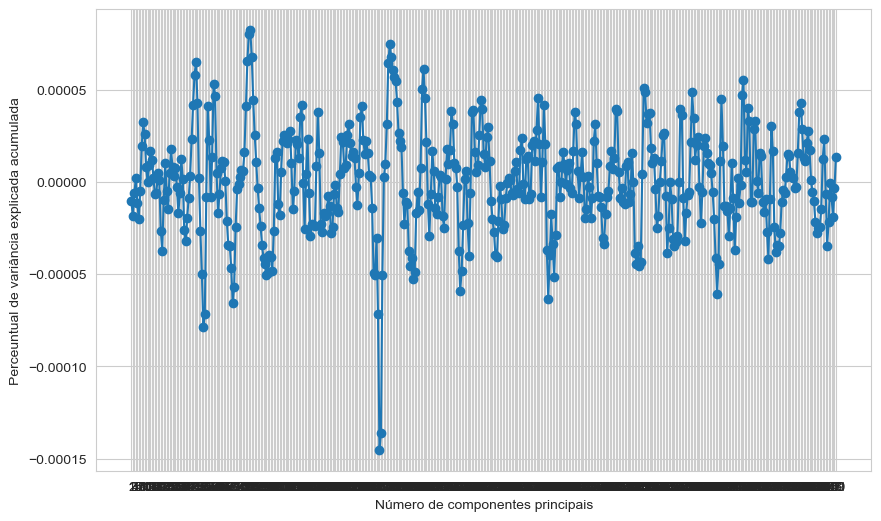

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, 482))
ax.plot(eixo_x, epochs_data_train[0][0], marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()

In [11]:
epochs_data_train.shape
# Number of events , channels, each measurement (f*t)

(4489, 64, 481)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(epochs_data_train, labels, test_size=0.3,shuffle = False, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2,shuffle = False, random_state=42)


In [13]:
concat_X_train = concat_channels("X_train")

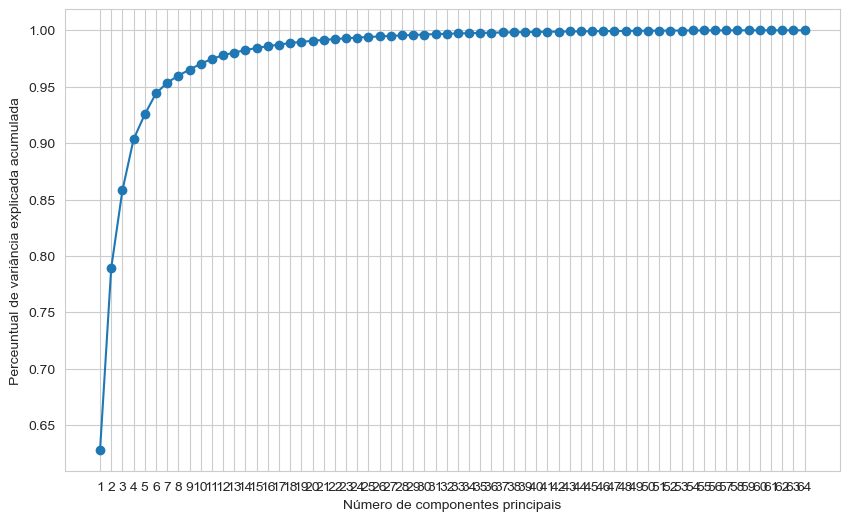

[0.627631 0.789262 0.858047 0.903368 0.925472 0.94401  0.953538 0.959789
 0.965163 0.97029  0.974701 0.977885 0.980324 0.982444 0.984361 0.9859
 0.987365 0.988701 0.989772 0.9907   0.991494 0.992246 0.992952 0.993555
 0.994088 0.994578 0.995042 0.995486 0.995886 0.996269 0.996625 0.996926
 0.997198 0.997445 0.997682 0.997905 0.998089 0.998261 0.998425 0.998584
 0.998729 0.998864 0.998989 0.999106 0.999217 0.999318 0.999412 0.999497
 0.999576 0.999649 0.999705 0.99976  0.999805 0.999845 0.999883 0.999911
 0.999933 0.999952 0.999964 0.999973 0.999981 0.999988 0.999994 1.      ] 0.9778846907903324


In [14]:
pca_channel = PCA(random_state=42,)
for event in X_train:
    pca_channel.fit(event.T)

variancia_explicada_acumulada_channel = np.cumsum(pca_channel.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel,variancia_explicada_acumulada_channel[12-1])

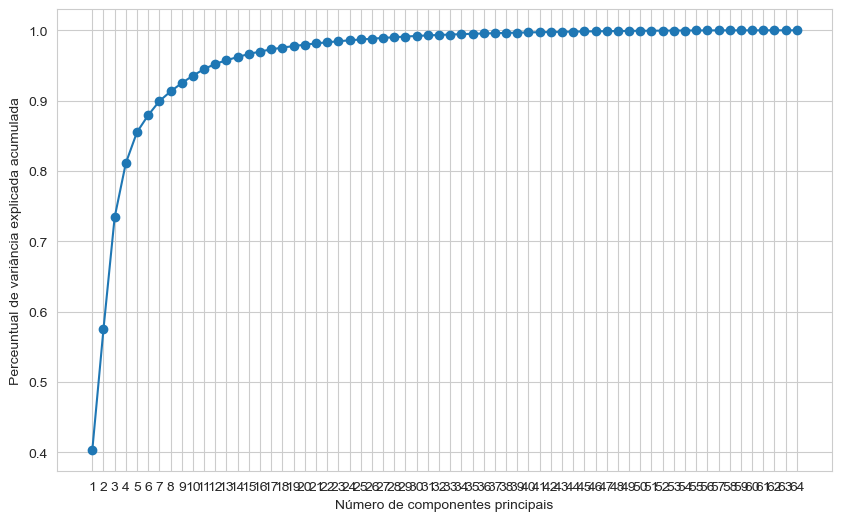

[0.40306  0.575212 0.734281 0.811269 0.855348 0.879381 0.899369 0.913101
 0.925009 0.935568 0.944895 0.952277 0.957487 0.962027 0.966362 0.969818
 0.972938 0.975425 0.977599 0.979526 0.981351 0.98301  0.984416 0.985788
 0.986973 0.988098 0.989175 0.9902   0.991114 0.991989 0.992758 0.993401
 0.993992 0.994547 0.995076 0.995503 0.995904 0.996285 0.996655 0.997011
 0.997336 0.997626 0.997897 0.998156 0.998395 0.998614 0.998816 0.998999
 0.999174 0.999304 0.999432 0.999537 0.999633 0.999724 0.999788 0.999843
 0.999887 0.999916 0.999936 0.999955 0.999972 0.999987 1.       1.      ] 0.9698179210161918


In [15]:
pca_data = PCA(random_state=42,)
for event in X_train:
    pca_data.fit(event)

variancia_explicada_acumulada_data = np.cumsum(pca_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_data,variancia_explicada_acumulada_data[16-1])

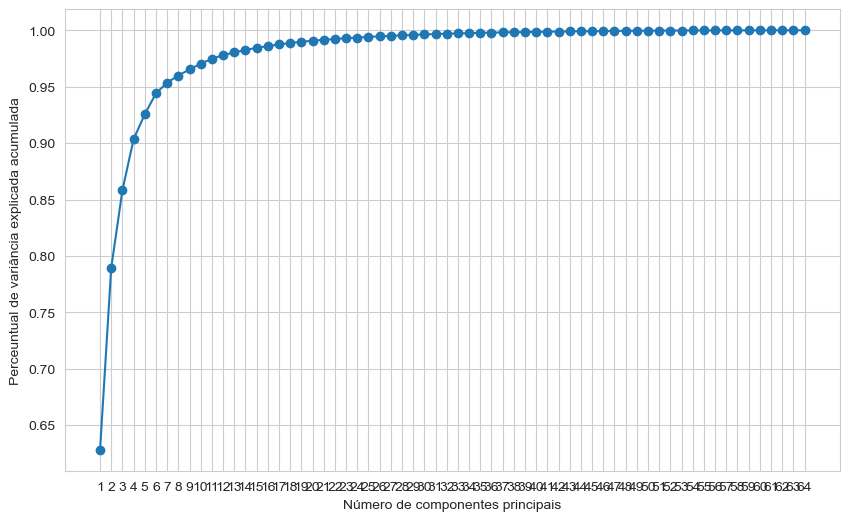

[0.627741 0.789391 0.858192 0.903488 0.925609 0.944113 0.953643 0.959907
 0.965304 0.970407 0.9748   0.97798  0.980421 0.982542 0.984454 0.985998
 0.987458 0.988785 0.989854 0.990781 0.991577 0.992328 0.993028 0.99363
 0.994163 0.994654 0.995118 0.995558 0.995959 0.996338 0.996687 0.996986
 0.997256 0.997504 0.997739 0.997957 0.998141 0.998313 0.998477 0.998633
 0.998777 0.99891  0.999034 0.99915  0.999258 0.999357 0.999449 0.999532
 0.999609 0.999675 0.999732 0.999782 0.999826 0.999865 0.999898 0.999923
 0.999944 0.99996  0.999971 0.99998  0.999987 0.999994 1.       1.      ] 0.9859984527119556


In [16]:
pca_channel_data = PCA(random_state=42,)
for event in transform_channel_per_event("X_train",pca_channel):
    pca_channel_data.fit(event)

variancia_explicada_acumulada_channel_data = np.cumsum(pca_channel_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel_data,variancia_explicada_acumulada_channel_data[16-1])

In [17]:
pca_all = PCA(random_state=42,)

pca_all.fit(concat_X_train)

PCA(random_state=42)

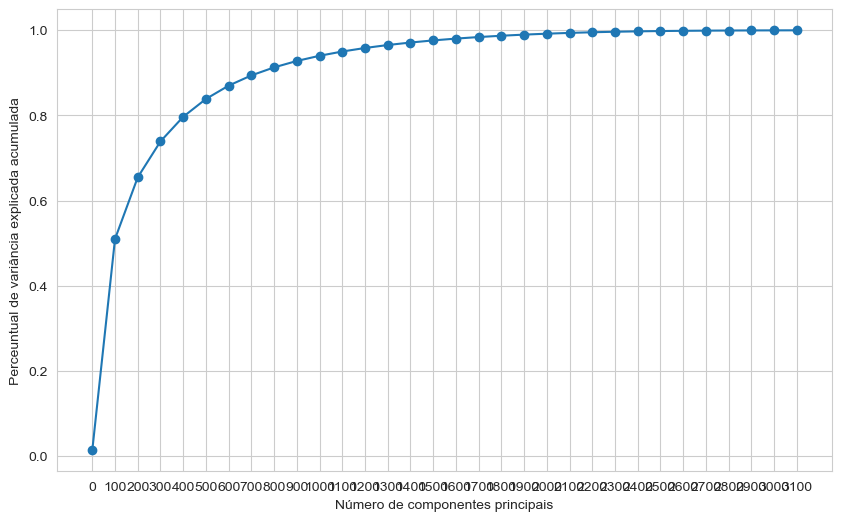

[0.013326 0.025752 0.037461 ... 1.       1.       1.      ] 0.9278469517442862


In [18]:

variancia_explicada_acumulada_all = np.cumsum(pca_all.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(0, len(variancia_explicada_acumulada_all)+1,100))
ax.plot(eixo_x, variancia_explicada_acumulada_all[0::100], marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_all,variancia_explicada_acumulada_all[900-1])

In [19]:
del pca_all
del pca_data
del pca_channel_data
del pca_channel


In [20]:
del variancia_explicada_acumulada_all
del variancia_explicada_acumulada_channel
del variancia_explicada_acumulada_channel_data
del variancia_explicada_acumulada_data

In [21]:
pca12_channel = PCA(random_state=42,n_components=12)
for event in X_train:
    pca12_channel.fit(event.T)

In [22]:
pca16_data = PCA(random_state=42,n_components=16)
for event in X_train:
    pca16_data.fit(event)

In [23]:
# pca900_all = PCA(random_state=42,n_components=900)
# pca900_all.fit(concat_X_train)

In [24]:
csp15 = mne.decoding.CSP(n_components=20, reg=None, log=True, norm_trace=False)
csp15.fit(X_train, y_train)


Computing rank from data with rank=None
    Using tolerance 0.0017 (2.2e-16 eps * 64 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0017 (2.2e-16 eps * 64 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 20,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [25]:

csp4 = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)
csp4.fit(X_train, y_train)

Computing rank from data with rank=None
    Using tolerance 0.0017 (2.2e-16 eps * 64 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0017 (2.2e-16 eps * 64 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [26]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

pca12_channel_csp4 = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)
pca12_channel_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 12 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 12 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [27]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

pca12_channel_csp15 = mne.decoding.CSP(n_components=20, reg=None, log=True, norm_trace=False)
pca12_channel_csp15.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 12 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 12 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 20,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [28]:
transform_list = []
for event in X_train:
    transform_list.append(pca16_data.transform(event).T)
transform_list = np.stack(transform_list, axis=2) 

pca16_data_csp4 = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)
pca16_data_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00092 (2.2e-16 eps * 64 dim * 6.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00092 (2.2e-16 eps * 64 dim * 6.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [29]:
transform_list = []
for event in X_train:
    transform_list.append(pca16_data.transform(event).T)
transform_list = np.stack(transform_list, axis=2) 

pca16_data_csp15 = mne.decoding.CSP(n_components=20, reg=None, log=True, norm_trace=False)
pca16_data_csp15.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00092 (2.2e-16 eps * 64 dim * 6.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00092 (2.2e-16 eps * 64 dim * 6.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 20,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [30]:
# umap15_unsup = UMAP(n_components=15,random_state=42,n_neighbors=30,min_dist=0.05)
# umap15_unsup.fit(X_train[:,0,:])

In [31]:
# umap15 = UMAP(n_components=16,random_state=42,n_neighbors=30,min_dist=0.05)
# for channel in range(64):
#     umap15.fit(X_train[:,channel,:],y_train)

In [32]:
# a = umap15.transform(X_val[:,0,:])
# fig, ax = plt.subplots()
# sns.scatterplot(ax = ax, x = a[:,0],y=  a[:,1], hue =  y_val,palette="tab10")
# ax.set_ylabel("Segunda componente")
# ax.set_xlabel("Primeira Componente")
# ax.legend(["Classe","T0","T1","T2"])
# ax.set_xticks(list(range(3, 6+1))) 
# ax.set_yticks(list(range(-2, 2+1)))
# plt.show()

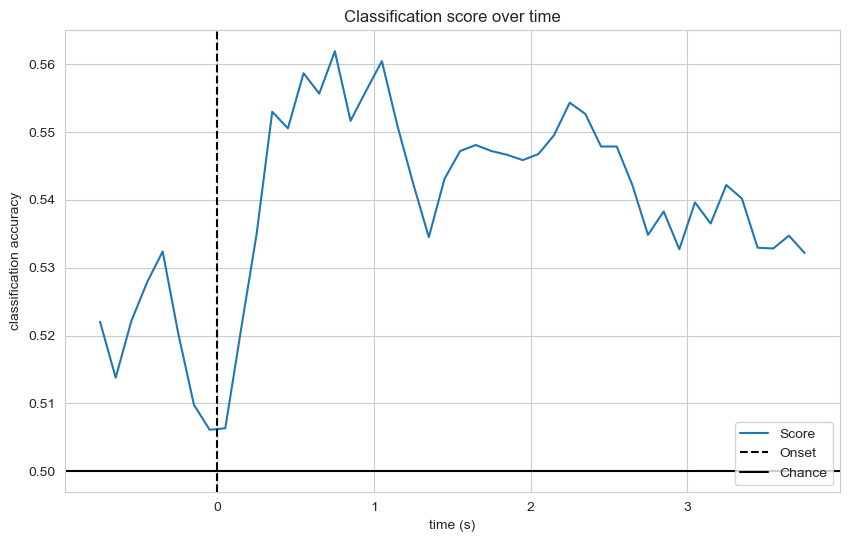

In [33]:
epochs_data_local = epochs.get_data()
epochs_data_train_local = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train_local)
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data_local.shape[2] - w_length, w_step)
lda = LinearDiscriminantAnalysis()

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train_local, y_test_local = labels[train_idx], labels[test_idx]

    X_train_local = csp4.transform(epochs_data_train_local[train_idx])

    # fit classifier
    lda.fit(X_train_local, y_train_local)

cv_split = cv.split(epochs_data_train_local)

for train_idx, test_idx in cv_split:
    y_train_local, y_test_local = labels[train_idx], labels[test_idx]
    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test_local = csp4.transform(epochs_data_local[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test_local, y_test_local))
    scores_windows.append(score_this_window)


# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [35]:
#Get Indices (it's the same for all, as suffle is False by default)
pipe = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
pipeline = pipe.create_pipeline()
cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True,return_indices=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

print(f"Results for pipeline with {pipe.name}:")
print("----------------")
print("Test accuracy scores:", cv_results['test_Accuracy'])
print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
print("-----")
print("Test F1 scores:", cv_results['test_F1'])
print("Mean test F1:", cv_results['test_F1'].mean())
print("----------------")
print("train accuracy scores:", cv_results['train_Accuracy'])
print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
print("-----")
print("train F1 scores:", cv_results['train_F1'])
print("Mean train F1:", cv_results['train_F1'].mean())
print("----------------")
print("Fit time:", cv_results['fit_time'])
print("Score time:", cv_results['score_time'])
print()
print("--------------------------------------------------------------------------------------------")

indices = cv_results["indices"]["test"]

Results for pipeline with lda_csp4:
----------------
Test accuracy scores: [0.552381 0.533333 0.5      0.550955 0.598726 0.515924 0.528662 0.550955
 0.487261 0.643312]
Mean test accuracy: 0.5461510464058235
-----
Test F1 scores: [0.551495 0.531046 0.492166 0.545306 0.590689 0.476667 0.518325 0.538788
 0.467152 0.632441]
Mean test F1: 0.5344075018978179
----------------
train accuracy scores: [0.551114 0.554298 0.557992 0.550919 0.545262 0.552334 0.557992 0.546322
 0.559052 0.540311]
Mean train accuracy: 0.5515595973160407
-----
train F1 scores: [0.549881 0.553279 0.557482 0.550214 0.544759 0.551526 0.557543 0.545672
 0.558511 0.538644]
Mean train F1: 0.5507510999245134
----------------
Fit time: [0.032002 0.002999 0.003    0.003003 0.003001 0.003001 0.003001 0.003
 0.002999 0.003001]
Score time: [0.120999 0.002997 0.002999 0.001998 0.002999 0.003001 0.001997 0.001999
 0.003004 0.001999]

--------------------------------------------------------------------------------------------


In [36]:
# results = {}
# for pipe in Pipes:
#     print(pipe.name)
#     # Create pipeline with the given pipe
#     pipeline = pipe.create_pipeline()
    
#     # Perform cross-validation
#     cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

#     print(f"Results for pipeline with {pipe.name}:")
#     print("----------------")
#     print("Test accuracy scores:", cv_results['test_Accuracy'])
#     print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
#     print("-----")
#     print("Test F1 scores:", cv_results['test_F1'])
#     print("Mean test F1:", cv_results['test_F1'].mean())
#     print("----------------")
#     print("train accuracy scores:", cv_results['train_Accuracy'])
#     print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
#     print("-----")
#     print("train F1 scores:", cv_results['train_F1'])
#     print("Mean train F1:", cv_results['train_F1'].mean())
#     print("----------------")
#     print("Fit time:", cv_results['fit_time'])
#     print("Score time:", cv_results['score_time'])
#     print()
#     print("--------------------------------------------------------------------------------------------")

#     results[pipe.name] = (cv_results)

In [37]:
# for key, value in results.items(): 
#     print(value['test_Accuracy'])
#     print(",")
# for key, value in results.items(): 
#     print(np.mean(value['test_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(np.max(value['test_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(value['test_F1'])
#     print(",")
# for key, value in results.items(): 
#     print(value['train_Accuracy'])
#     print(",")
# for key, value in results.items(): 
#     print(np.mean(value['train_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(np.max(value['train_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(value['train_F1'])
#     print(",")
# for key, value in results.items(): 
#     print(value['fit_time'])
#     print(",")
# for key, value in results.items(): 
#     print(value['score_time'])
#     print(",")
# - Todos os modelos que receberam apenas PCA não foram capaz de apresentar uma acurária significativamente maior que chance level.
# - O melhor modelo em todas as configurações foi a junção do PCA_data com CSP15
# - Em todos os modelos, a segunda maior média pertence ao modelo CSP15 ou PCA_data com CSP4
# - O melhor modelo foi o LDA, seguido pelo Keras
# f = []
# for key, value in results.items(): 
#     f.append(value['train_Accuracy'])

# np.mean(np.array(f), axis=0)
# f = []
# for key, value in results.items(): 
#     f.append(value['test_Accuracy'])

# np.mean(np.array(f), axis=0)
# Podemos notar que a última separação de treino e teste teve um resultado notavelmente maior que os demais, enquanto as separações 2,3,7,8 foram as piores.
# X_train[indices[9]].shape
# np.floor(np.sqrt(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15).shape[1]+3))

In [46]:
def aff(array):
    X_std = (array - np.min(array)) / (np.max(array) - np.min(array))
    X_scaled = X_std * (1-0)+0
    return X_scaled

In [47]:
# lda_plain = Pipe("lda_csp4",LinearDiscriminantAnalysis(),concat_channels("X_train") ) - Takes too long
lda_csp4 = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
lda_csp15 = Pipe("lda_csp15",LinearDiscriminantAnalysis(),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
lda_pca12_channel_csp4 = Pipe("lda_pca12_channel_csp4",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
lda_pca16_data_csp4 = Pipe("lda_pca16_data_csp4",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# lda_pca900_all = Pipe("lda_pca900_all",LinearDiscriminantAnalysis(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
lda_pca12_channel = Pipe("lda_pca12_channel",LinearDiscriminantAnalysis(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
lda_pca16_data = Pipe("lda_pca16_data",LinearDiscriminantAnalysis(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
lda_pca12_channel_csp15 = Pipe("lda_pca12_channel_csp15",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
lda_pca16_data_csp15 = Pipe("lda_pca16_data_csp15",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# mnbc_plain = Pipe("mnbc_plain",MultinomialNB(),concat_channels("X_train"),aff)
mnbc_csp4 = Pipe("mnbc_csp4",MultinomialNB(),transform_csp("X_train",csp4),transform_csp("X_val",csp4),aff)
mnbc_csp15 = Pipe("mnbc_csp15",MultinomialNB(),transform_csp("X_train",csp15),transform_csp("X_val",csp15),aff)
mnbc_pca12_channel = Pipe("mnbc_pca12_channel",MultinomialNB(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel),aff)
mnbc_pca16_data = Pipe("mnbc_pca16_data",MultinomialNB(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data),aff)
# # # # # # mnbc_pca900_all = Pipe("mnbc_pca900_all",MultinomialNB(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all),aff)
mnbc_pca12_channel_csp4 = Pipe("mnbc_pca12_channel_csp4",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4),aff)
mnbc_pca16_data_csp4 = Pipe("mnbc_pca16_data_csp4",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4),aff)
mnbc_pca12_channel_csp15 = Pipe("mnbc_pca12_channel_csp15",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15),aff)
mnbc_pca16_data_csp15 = Pipe("mnbc_pca16_data_csp15",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15),aff)
# MLP_plain = Pipe("MLP_plain",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),concat_channels("X_train")) - Takes too long
MLP_csp4 = Pipe("MLP_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
MLP_csp15 = Pipe("MLP_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
MLP_pca12_channel = Pipe("MLP_pca12_channel",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
MLP_pca16_data = Pipe("MLP_pca16_data",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # # # # # MLP_pca900_all = Pipe("MLP_pca900_all",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
MLP_pca12_channel_csp4 = Pipe("MLP_pca12_channel_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
MLP_pca16_data_csp4 = Pipe("MLP_pca16_data_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
MLP_pca12_channel_csp15 = Pipe("MLP_pca12_channel_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
MLP_pca16_data_csp15 = Pipe("MLP_pca16_data_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
Keras_MLP_csp4 = Pipe("Keras_MLP_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp4).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
Keras_MLP_csp15 = Pipe("Keras_MLP_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp15).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp15),transform_csp("X_val",csp15))

Keras_MLP_pca12_channel = Pipe("Keras_MLP_pca12_channel",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_concat("X_train",pca12_channel).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
Keras_MLP_pca16_data = Pipe("Keras_MLP_pca16_data",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_concat("X_train",pca16_data).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # # Keras_MLP_pca900_all = Pipe("Keras_MLP_pca900_all",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             # # tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_all_concat("X_train",pca900_all).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     # # # # }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))



Keras_MLP_pca16_data_csp4 = Pipe("Keras_MLP_pca16_data_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
Keras_MLP_pca12_channel_csp4 = Pipe("Keras_MLP_pca12_channel_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
Keras_MLP_pca16_data_csp15 = Pipe("Keras_MLP_pca16_data_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
Keras_MLP_pca12_channel_csp15 = Pipe("Keras_MLP_pca12_channel_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))




Pipes = [
    lda_csp4,
    lda_csp15,
    lda_pca12_channel_csp4,
    lda_pca12_channel_csp15,
    lda_pca16_data_csp4,
    lda_pca16_data_csp15,
    # mnbc_plain,
    mnbc_csp4,
    mnbc_csp15,
    mnbc_pca12_channel_csp4,
    mnbc_pca12_channel_csp15,
    mnbc_pca16_data_csp4,
    mnbc_pca16_data_csp15,
    # MLP_plain,
    MLP_csp4,
    MLP_csp15,
    MLP_pca12_channel_csp4,
    MLP_pca12_channel_csp15,
    MLP_pca16_data_csp4,
    MLP_pca16_data_csp15,
    Keras_MLP_csp4,
    Keras_MLP_csp15,
    Keras_MLP_pca12_channel_csp4,
    Keras_MLP_pca12_channel_csp15,
    Keras_MLP_pca16_data_csp4,
    Keras_MLP_pca16_data_csp15,
    
    
    lda_pca12_channel,
    lda_pca16_data,
    # lda_pca900_all,
    
    mnbc_pca12_channel,
    mnbc_pca16_data,
    # mnbc_pca900_all,
    MLP_pca12_channel,
    MLP_pca16_data,
    # MLP_pca900_all,
    Keras_MLP_pca12_channel,
    Keras_MLP_pca16_data,
    # Keras_MLP_pca900_all,
]


In [48]:
results_val = {}
for pipe in Pipes:
    print(pipe.name)
    # Create pipeline with the given pipe
    pipeline = pipe.create_pipeline()
    
    # Perform cross-validation
    pipeline.fit( pipe.processed_X_train, y_train)
    train_score = pipeline.score(pipe.processed_X_train,y_train)
    val_score = pipeline.score(pipe.processed_X_val,y_val)


    print(f"Results for pipeline with {pipe.name}:")
    print("----------------")
    print("Test accuracy scores:", val_score)
    print("----------------")
    print("train accuracy scores:", train_score)
    print()
    print("--------------------------------------------------------------------------------------------")

    results_val[pipe.name] = (pipeline)
    


lda_csp4
Results for pipeline with lda_csp4:
----------------
Test accuracy scores: 0.5352635486265775
----------------
train accuracy scores: 0.5528325907065563

--------------------------------------------------------------------------------------------
lda_csp15
Results for pipeline with lda_csp15:
----------------
Test accuracy scores: 0.5545657015590201
----------------
train accuracy scores: 0.6085295989815405

--------------------------------------------------------------------------------------------
lda_pca12_channel_csp4
Results for pipeline with lda_pca12_channel_csp4:
----------------
Test accuracy scores: 0.5805493689680772
----------------
train accuracy scores: 0.5856142584341184

--------------------------------------------------------------------------------------------
lda_pca12_channel_csp15
Results for pipeline with lda_pca12_channel_csp15:
----------------
Test accuracy scores: 0.5671863400148478
----------------
train accuracy scores: 0.5900700190961171

---------

              precision    recall  f1-score   support

           0     0.5404    0.4763    0.5063       674
           1     0.5312    0.5944    0.5610       673

    accuracy                         0.5353      1347
   macro avg     0.5358    0.5353    0.5337      1347
weighted avg     0.5358    0.5353    0.5336      1347



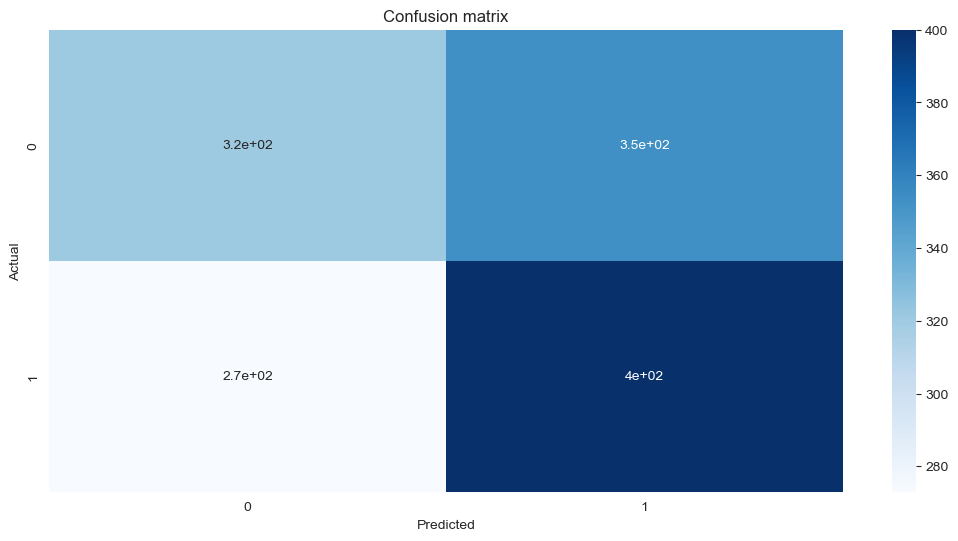

              precision    recall  f1-score   support

           0     0.5607    0.5074    0.5327       674
           1     0.5495    0.6018    0.5745       673

    accuracy                         0.5546      1347
   macro avg     0.5551    0.5546    0.5536      1347
weighted avg     0.5551    0.5546    0.5536      1347



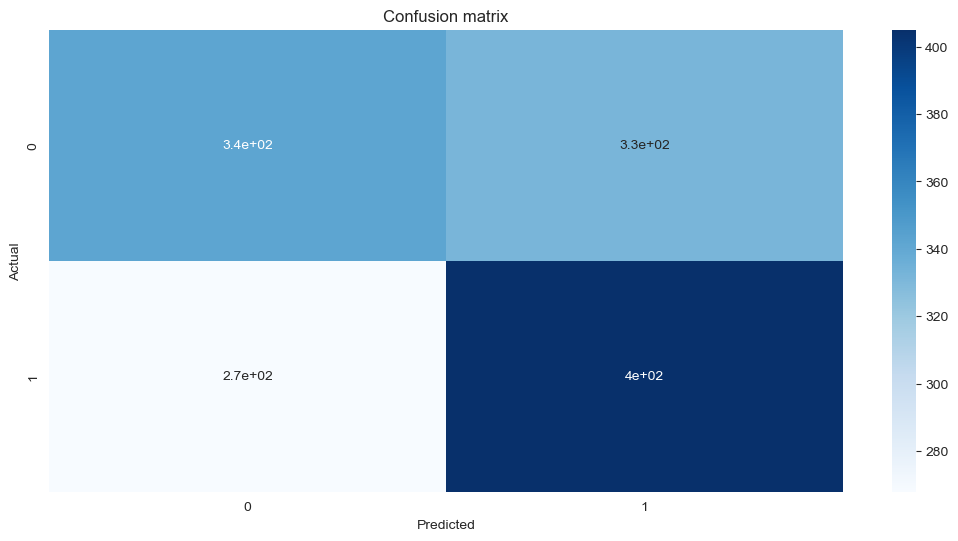

              precision    recall  f1-score   support

           0     0.5889    0.5356    0.5610       674
           1     0.5736    0.6256    0.5984       673

    accuracy                         0.5805      1347
   macro avg     0.5812    0.5806    0.5797      1347
weighted avg     0.5812    0.5805    0.5797      1347



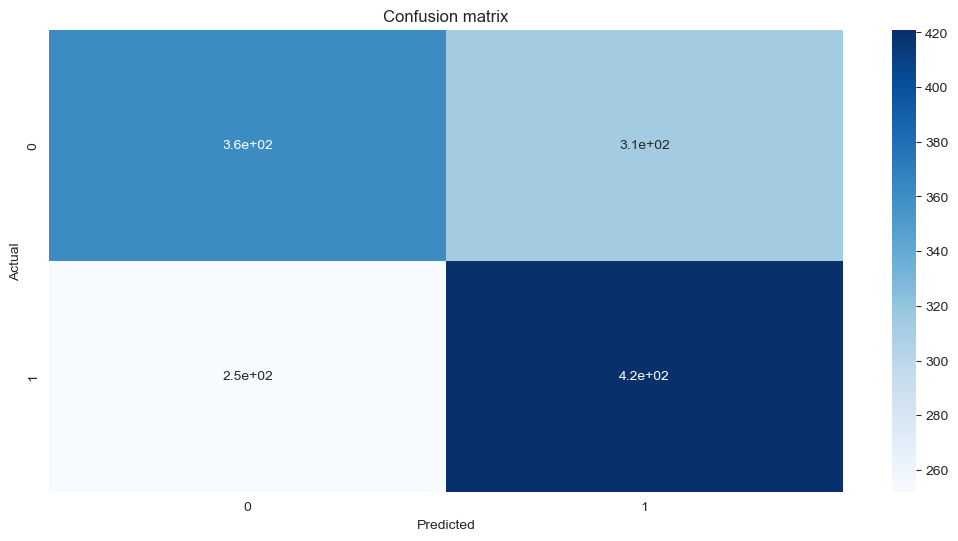

              precision    recall  f1-score   support

           0     0.5705    0.5460    0.5580       674
           1     0.5641    0.5884    0.5760       673

    accuracy                         0.5672      1347
   macro avg     0.5673    0.5672    0.5670      1347
weighted avg     0.5673    0.5672    0.5670      1347



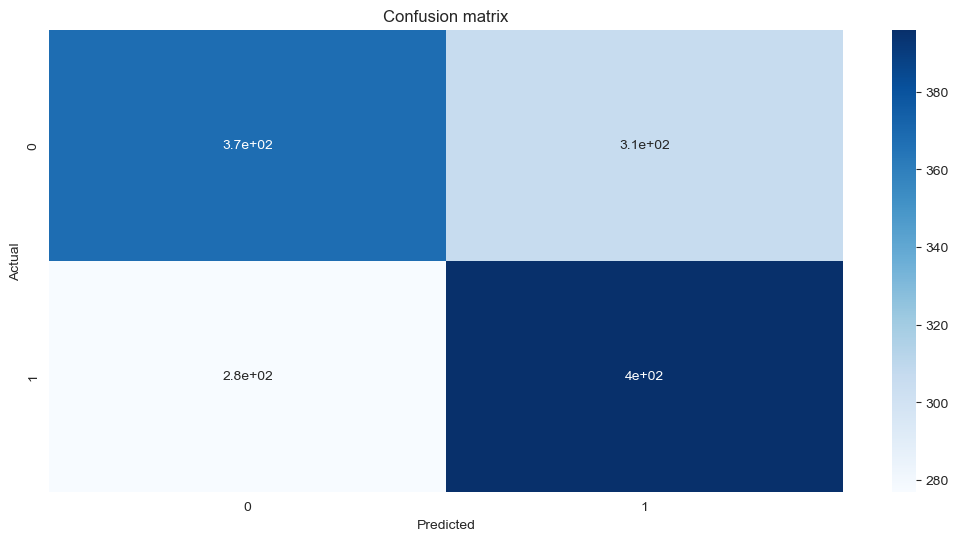

              precision    recall  f1-score   support

           0     0.5321    0.4792    0.5043       674
           1     0.5257    0.5780    0.5506       673

    accuracy                         0.5286      1347
   macro avg     0.5289    0.5286    0.5274      1347
weighted avg     0.5289    0.5286    0.5274      1347



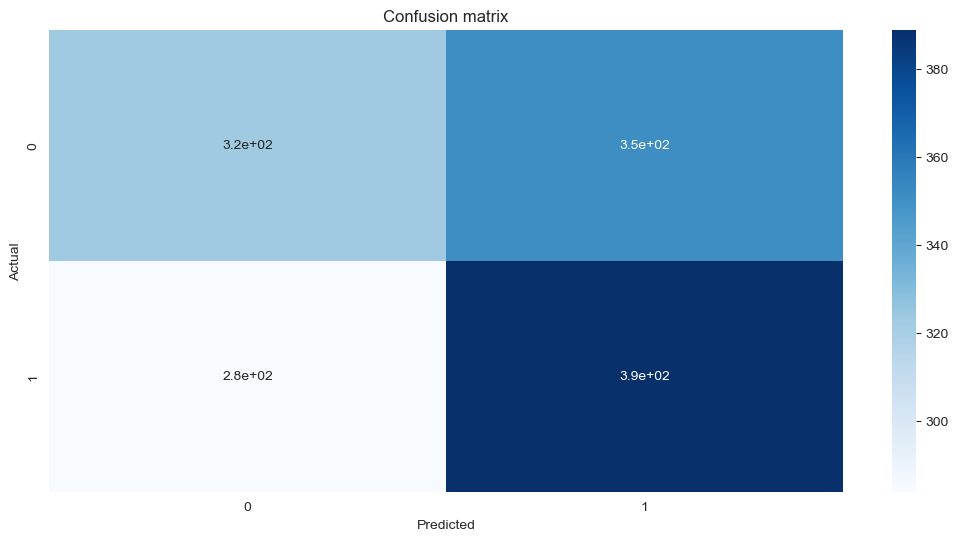

              precision    recall  f1-score   support

           0     0.5316    0.5371    0.5343       674
           1     0.5315    0.5260    0.5288       673

    accuracy                         0.5316      1347
   macro avg     0.5316    0.5315    0.5315      1347
weighted avg     0.5316    0.5316    0.5315      1347



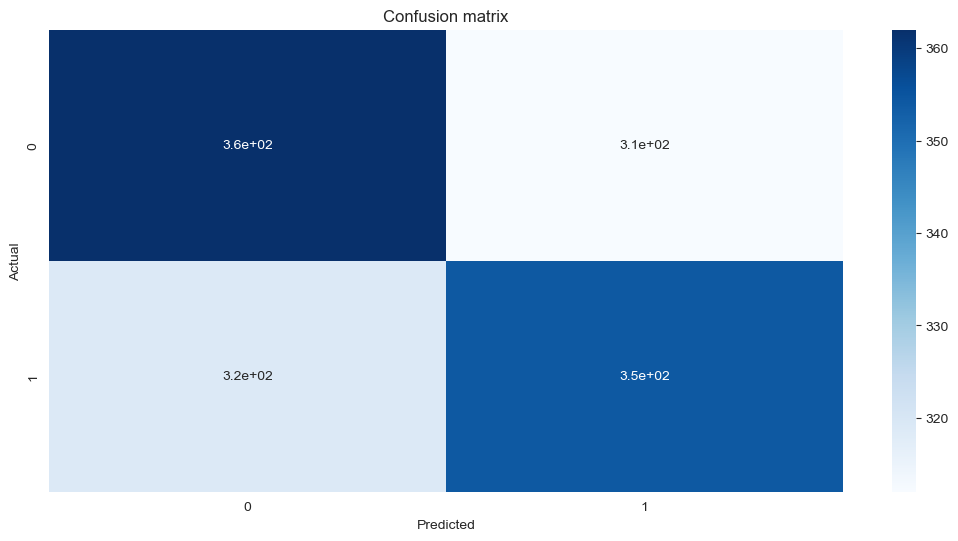

              precision    recall  f1-score   support

           0     0.5482    0.2700    0.3618       674
           1     0.5153    0.7771    0.6197       673

    accuracy                         0.5234      1347
   macro avg     0.5317    0.5236    0.4907      1347
weighted avg     0.5317    0.5234    0.4907      1347



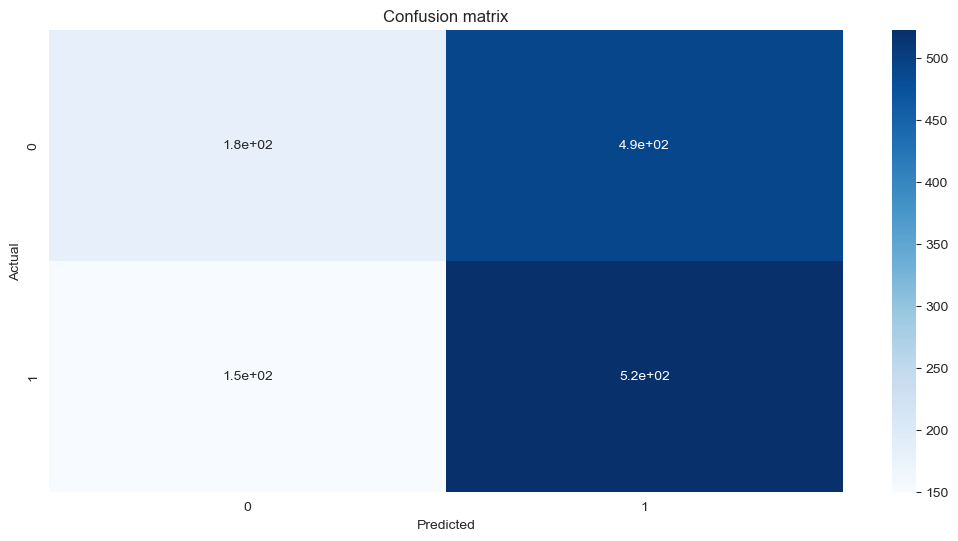

              precision    recall  f1-score   support

           0     0.5384    0.6350    0.5827       674
           1     0.5543    0.4547    0.4996       673

    accuracy                         0.5449      1347
   macro avg     0.5464    0.5448    0.5412      1347
weighted avg     0.5464    0.5449    0.5412      1347



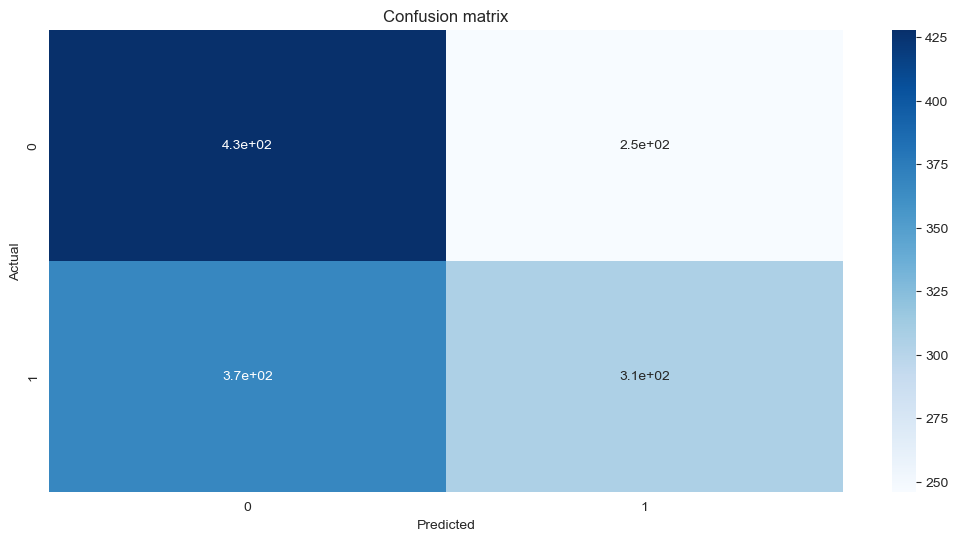

              precision    recall  f1-score   support

           0     0.5448    0.7315    0.6244       674
           1     0.5905    0.3878    0.4682       673

    accuracy                         0.5598      1347
   macro avg     0.5676    0.5596    0.5463      1347
weighted avg     0.5676    0.5598    0.5464      1347



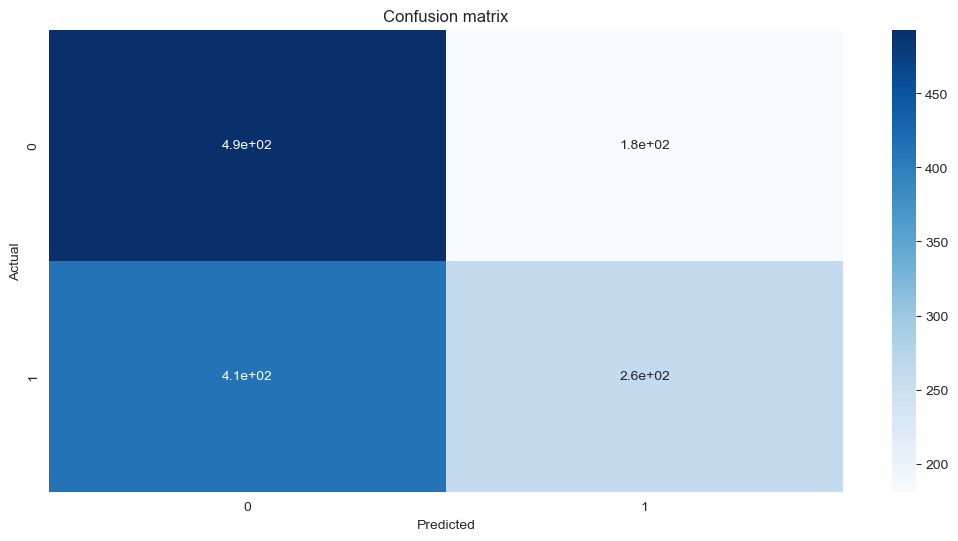

              precision    recall  f1-score   support

           0     0.5432    0.7374    0.6256       674
           1     0.5903    0.3789    0.4615       673

    accuracy                         0.5583      1347
   macro avg     0.5667    0.5581    0.5435      1347
weighted avg     0.5667    0.5583    0.5436      1347



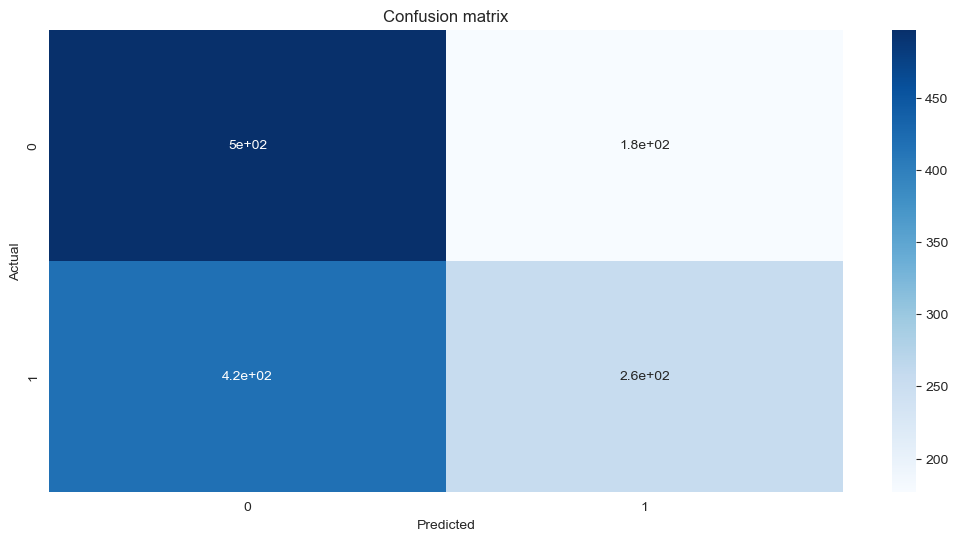

              precision    recall  f1-score   support

           0     0.5238    0.3917    0.4482       674
           1     0.5136    0.6434    0.5712       673

    accuracy                         0.5174      1347
   macro avg     0.5187    0.5175    0.5097      1347
weighted avg     0.5187    0.5174    0.5097      1347



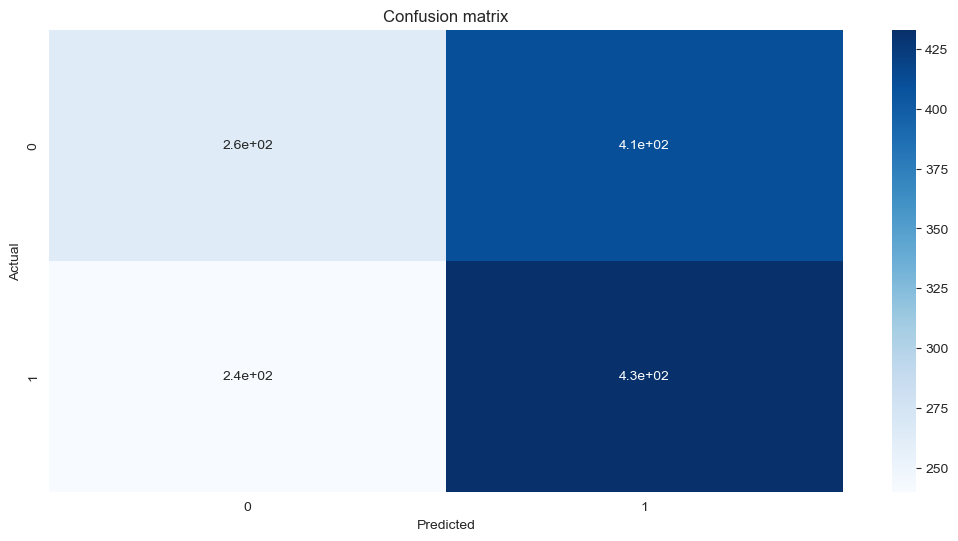

              precision    recall  f1-score   support

           0     0.5574    0.3961    0.4631       674
           1     0.5311    0.6850    0.5983       673

    accuracy                         0.5405      1347
   macro avg     0.5443    0.5406    0.5307      1347
weighted avg     0.5443    0.5405    0.5307      1347



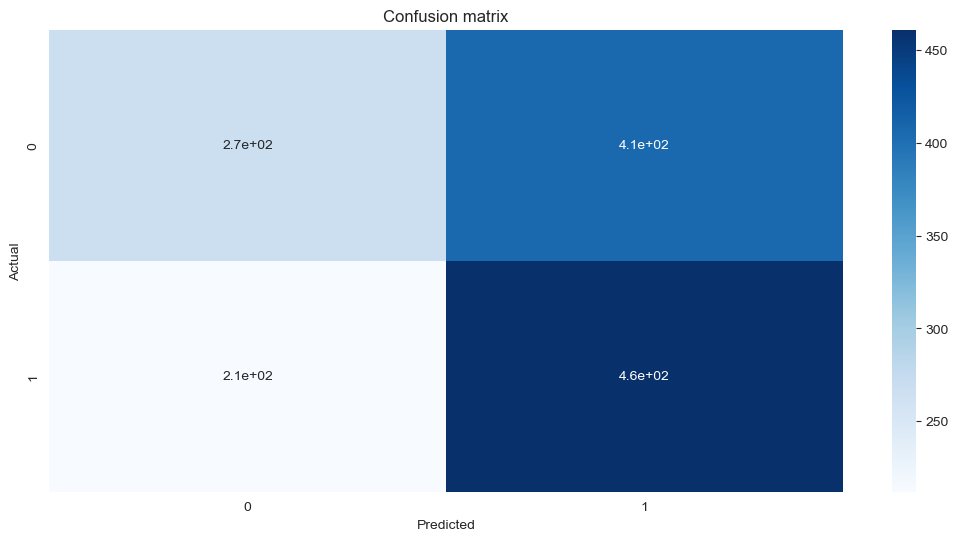

              precision    recall  f1-score   support

           0     0.5295    0.7315    0.6143       674
           1     0.5649    0.3492    0.4316       673

    accuracy                         0.5405      1347
   macro avg     0.5472    0.5403    0.5230      1347
weighted avg     0.5472    0.5405    0.5230      1347



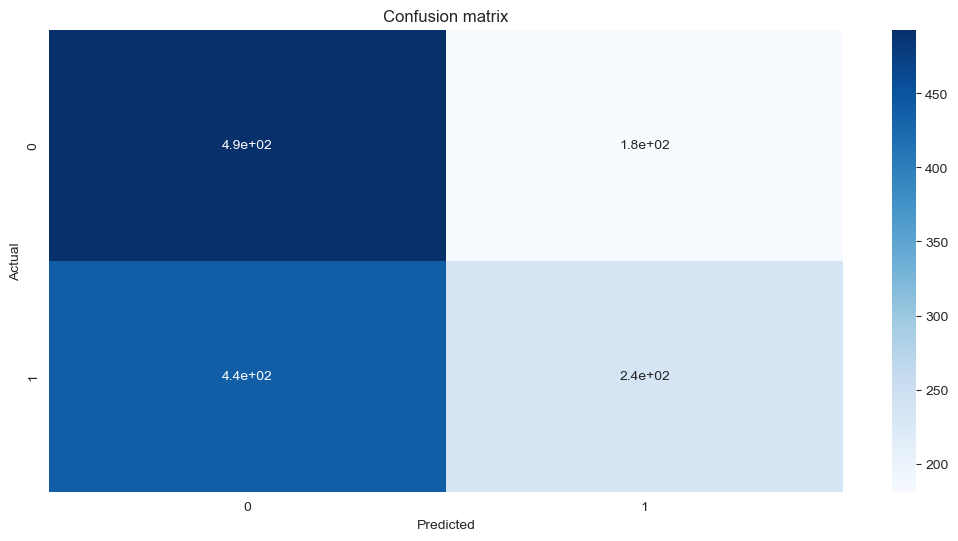

              precision    recall  f1-score   support

           0     0.5586    0.4599    0.5045       674
           1     0.5404    0.6360    0.5843       673

    accuracy                         0.5479      1347
   macro avg     0.5495    0.5479    0.5444      1347
weighted avg     0.5495    0.5479    0.5444      1347



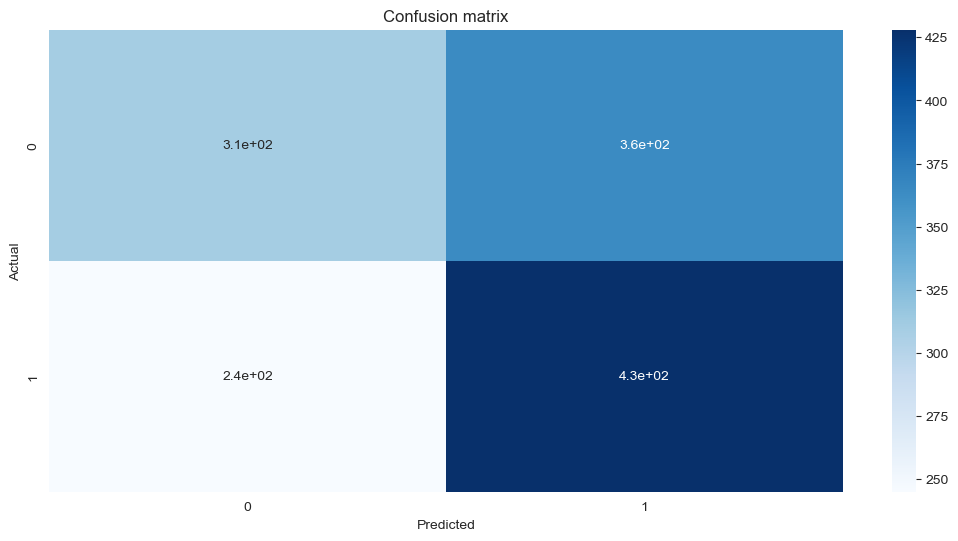

              precision    recall  f1-score   support

           0     0.5608    0.4792    0.5168       674
           1     0.5447    0.6241    0.5817       673

    accuracy                         0.5516      1347
   macro avg     0.5528    0.5516    0.5493      1347
weighted avg     0.5528    0.5516    0.5492      1347



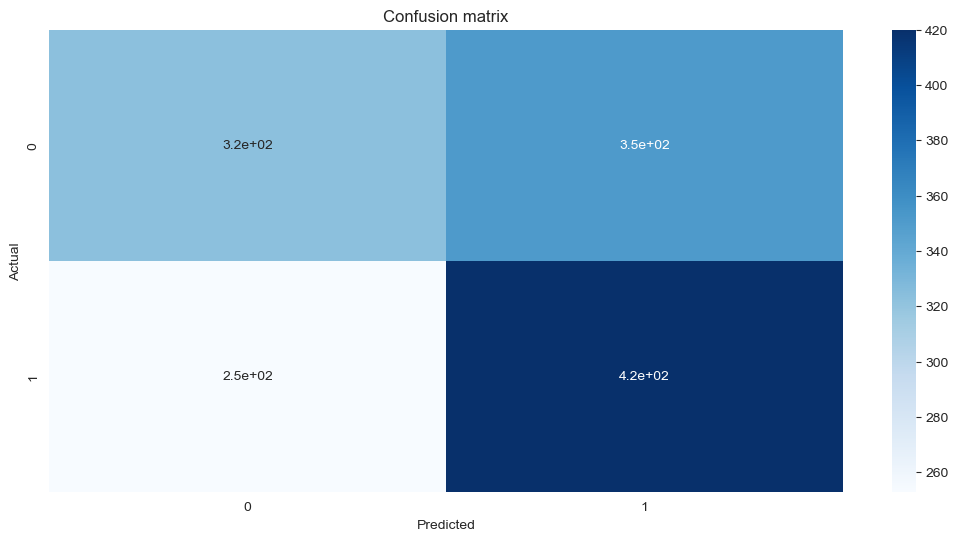

              precision    recall  f1-score   support

           0     0.5505    0.5252    0.5376       674
           1     0.5455    0.5706    0.5577       673

    accuracy                         0.5479      1347
   macro avg     0.5480    0.5479    0.5477      1347
weighted avg     0.5480    0.5479    0.5477      1347



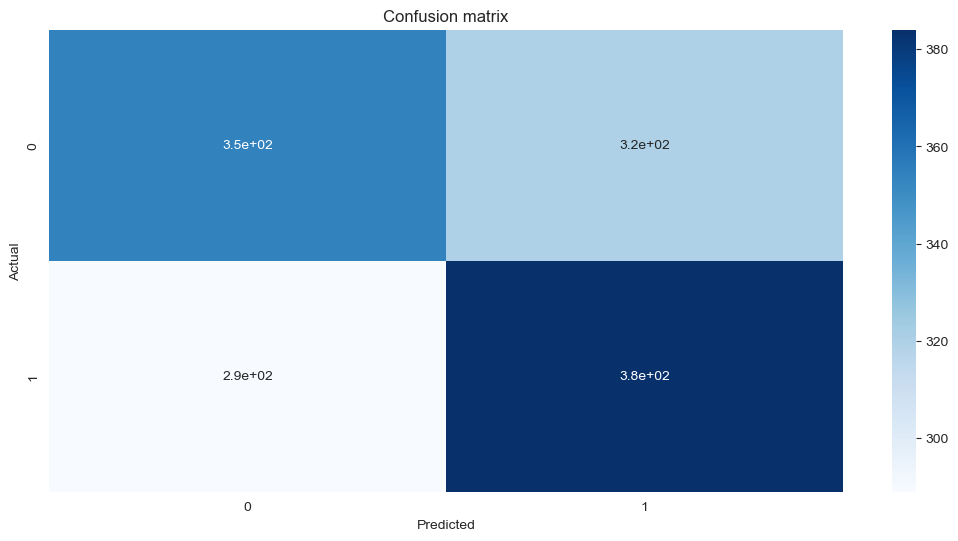

              precision    recall  f1-score   support

           0     0.5127    0.5074    0.5101       674
           1     0.5118    0.5171    0.5144       673

    accuracy                         0.5122      1347
   macro avg     0.5123    0.5123    0.5122      1347
weighted avg     0.5123    0.5122    0.5122      1347



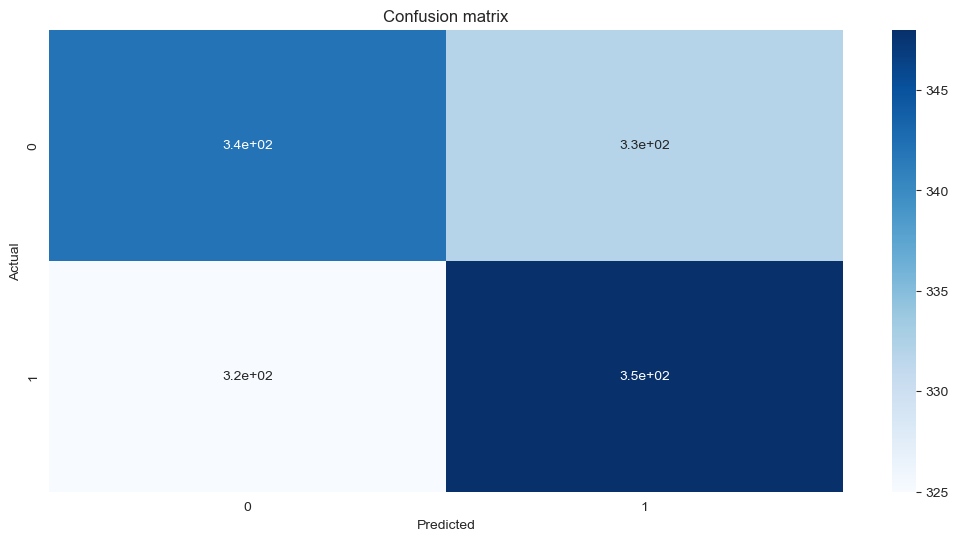

c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       674
           1     0.4996    1.0000    0.6663       673

    accuracy                         0.4996      1347
   macro avg     0.2498    0.5000    0.3332      1347
weighted avg     0.2496    0.4996    0.3329      1347



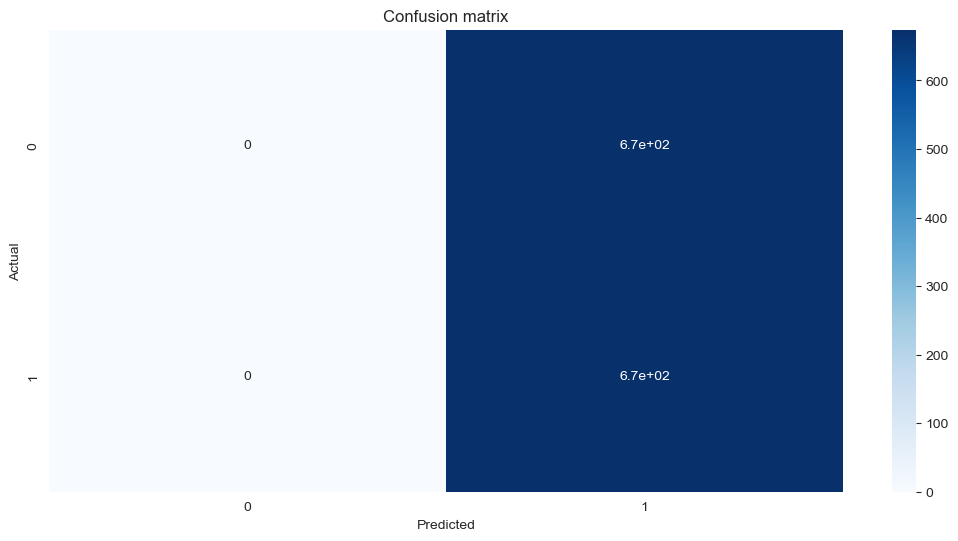

              precision    recall  f1-score   support

           0     0.5200    0.7893    0.6270       674
           1     0.5617    0.2704    0.3651       673

    accuracy                         0.5301      1347
   macro avg     0.5409    0.5299    0.4960      1347
weighted avg     0.5409    0.5301    0.4961      1347



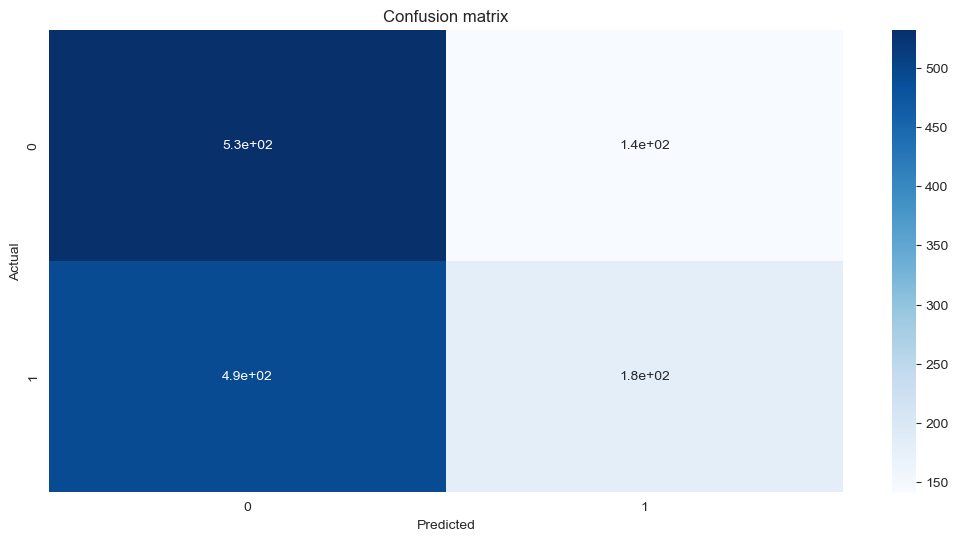

              precision    recall  f1-score   support

           0     0.5421    0.6113    0.5746       674
           1     0.5537    0.4829    0.5159       673

    accuracy                         0.5471      1347
   macro avg     0.5479    0.5471    0.5452      1347
weighted avg     0.5479    0.5471    0.5453      1347



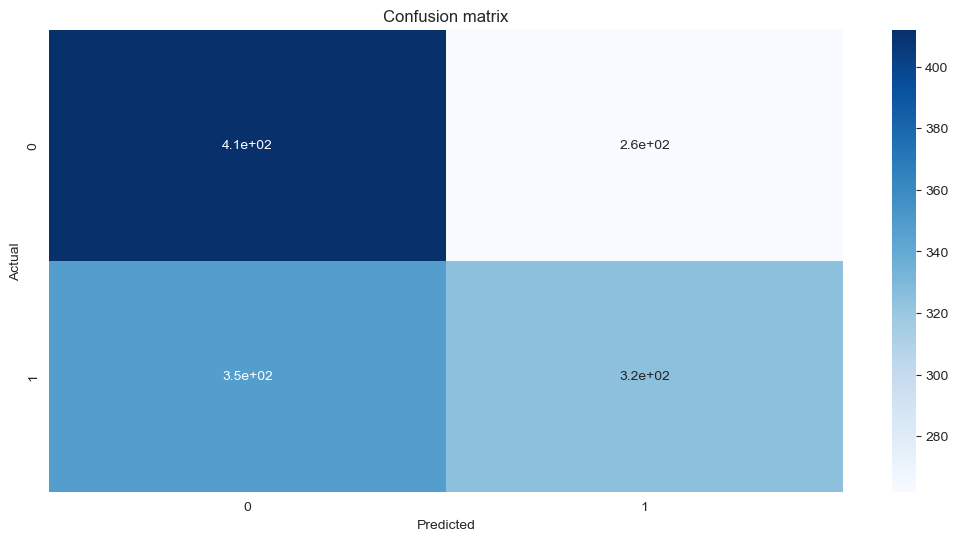

              precision    recall  f1-score   support

           0     0.5759    0.6246    0.5993       674
           1     0.5893    0.5394    0.5632       673

    accuracy                         0.5820      1347
   macro avg     0.5826    0.5820    0.5813      1347
weighted avg     0.5826    0.5820    0.5813      1347



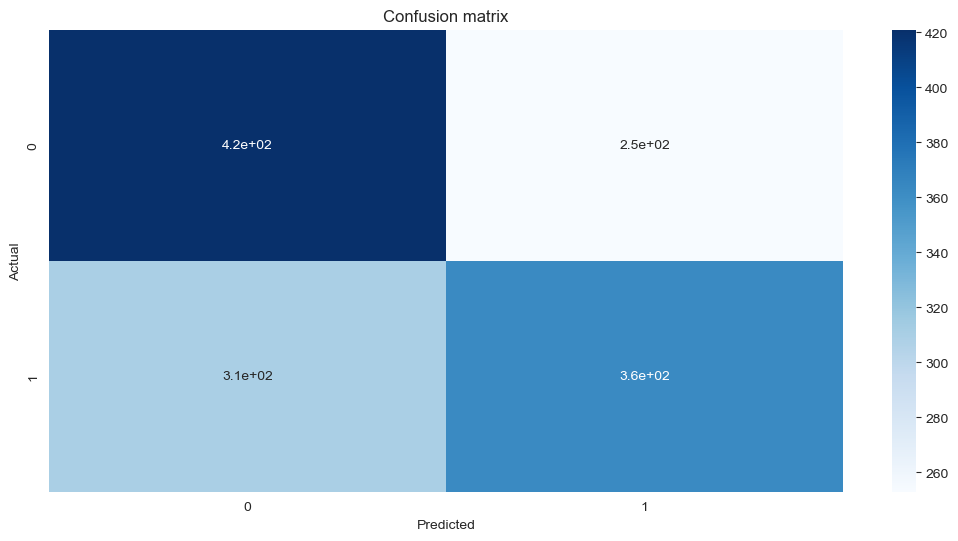

              precision    recall  f1-score   support

           0     0.5652    0.5920    0.5783       674
           1     0.5710    0.5438    0.5571       673

    accuracy                         0.5679      1347
   macro avg     0.5681    0.5679    0.5677      1347
weighted avg     0.5681    0.5679    0.5677      1347



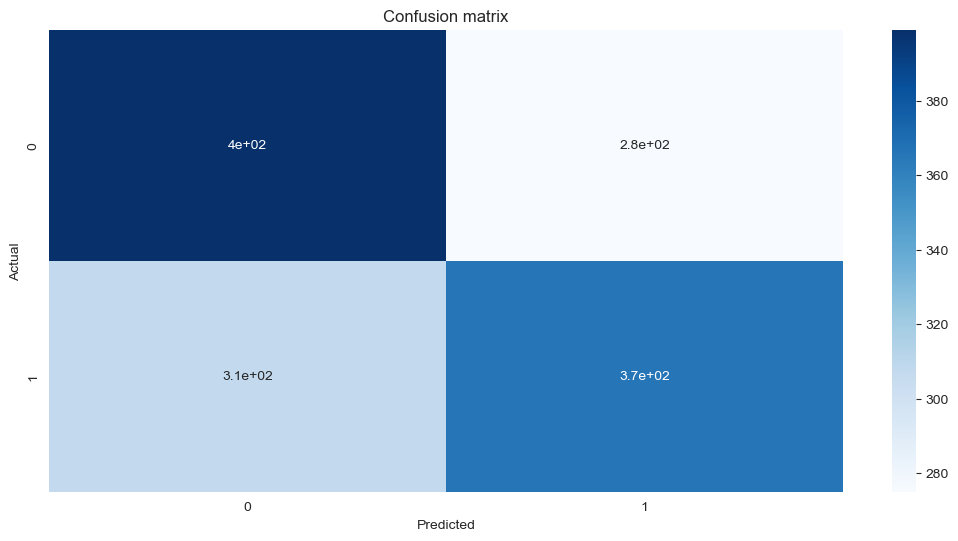

              precision    recall  f1-score   support

           0     0.5319    0.5326    0.5322       674
           1     0.5312    0.5305    0.5309       673

    accuracy                         0.5316      1347
   macro avg     0.5316    0.5316    0.5316      1347
weighted avg     0.5316    0.5316    0.5316      1347



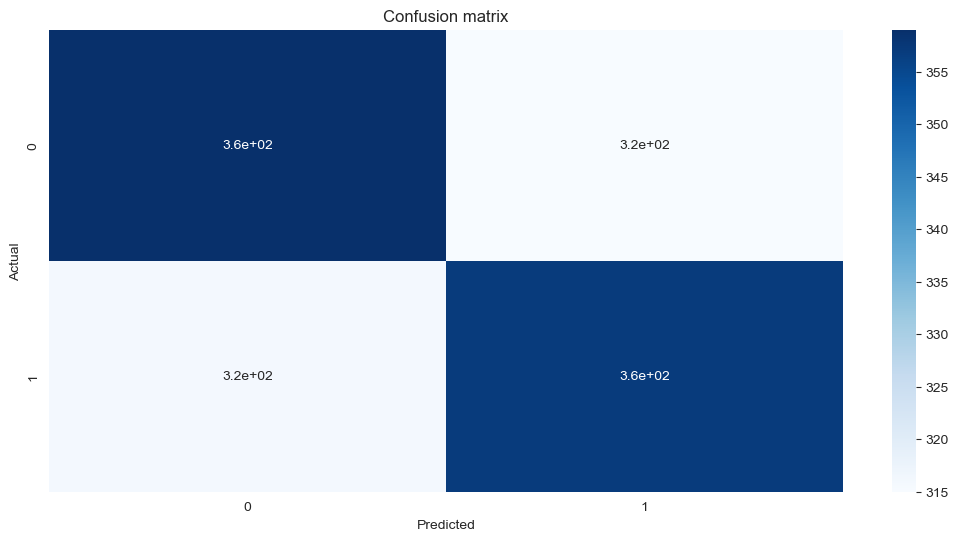

              precision    recall  f1-score   support

           0     0.5266    0.4852    0.5050       674
           1     0.5220    0.5632    0.5418       673

    accuracy                         0.5241      1347
   macro avg     0.5243    0.5242    0.5234      1347
weighted avg     0.5243    0.5241    0.5234      1347



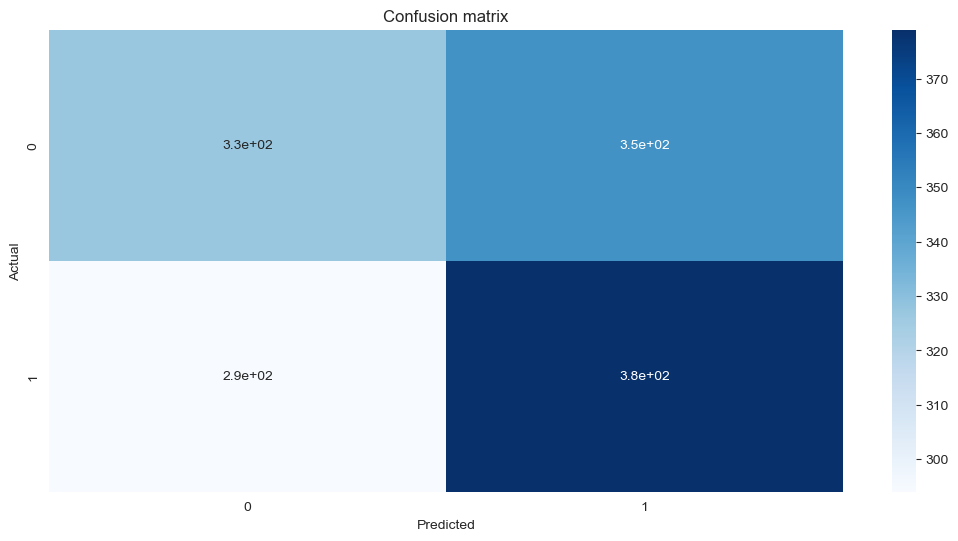

              precision    recall  f1-score   support

           0     0.5196    0.5312    0.5253       674
           1     0.5198    0.5082    0.5139       673

    accuracy                         0.5197      1347
   macro avg     0.5197    0.5197    0.5196      1347
weighted avg     0.5197    0.5197    0.5196      1347



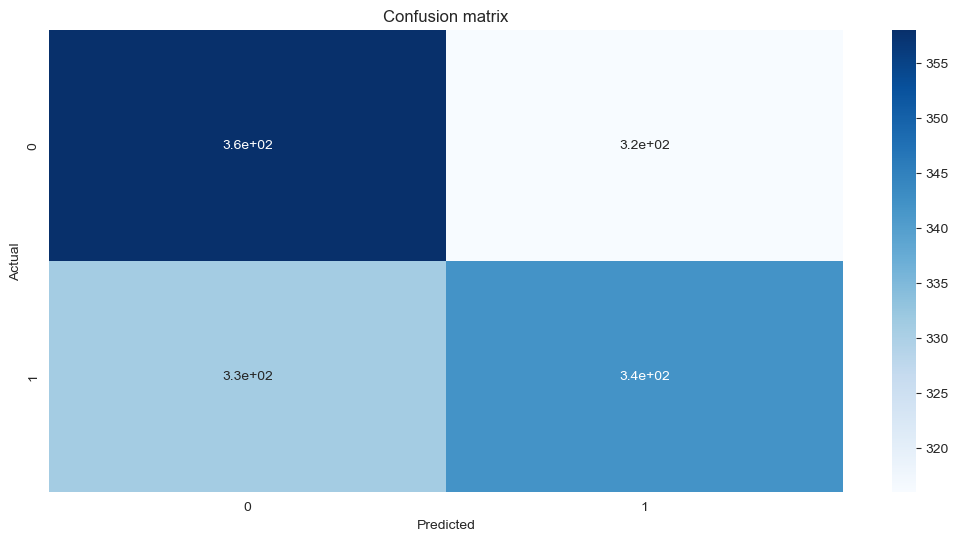

              precision    recall  f1-score   support

           0     0.5158    0.5326    0.5241       674
           1     0.5161    0.4993    0.5076       673

    accuracy                         0.5160      1347
   macro avg     0.5160    0.5159    0.5158      1347
weighted avg     0.5160    0.5160    0.5158      1347



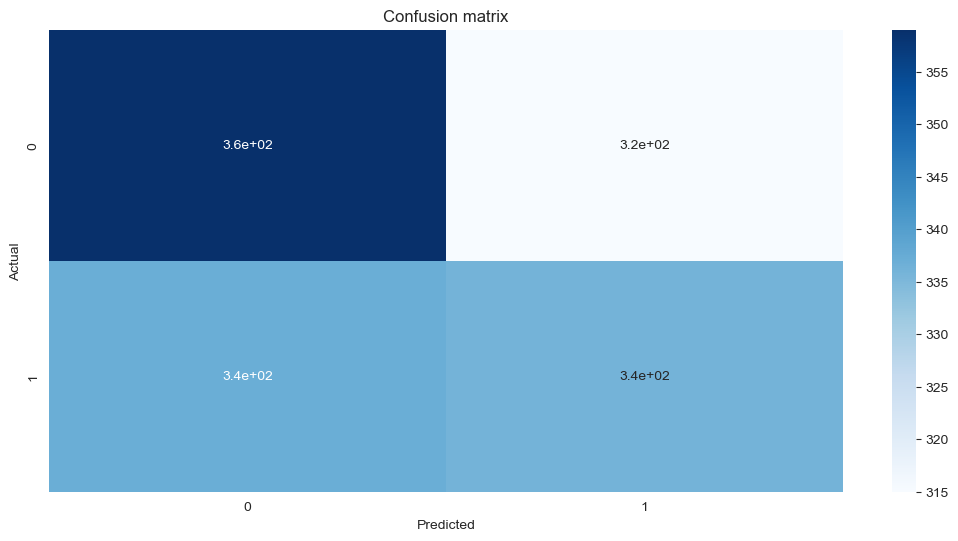

c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



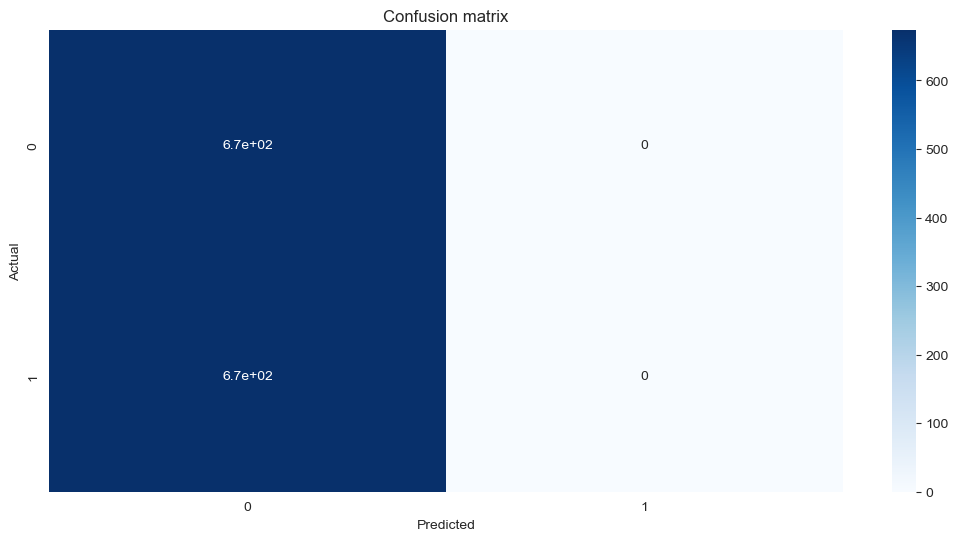

c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



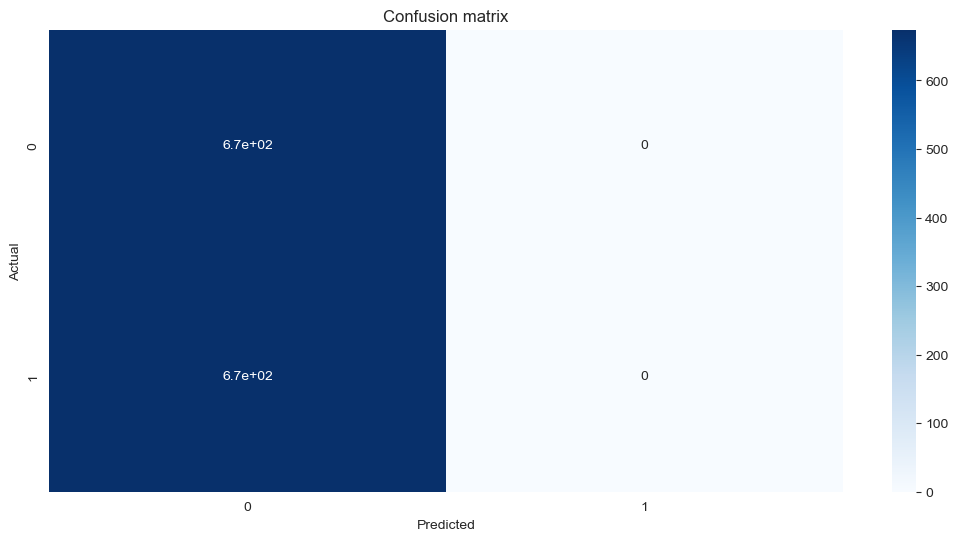

c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



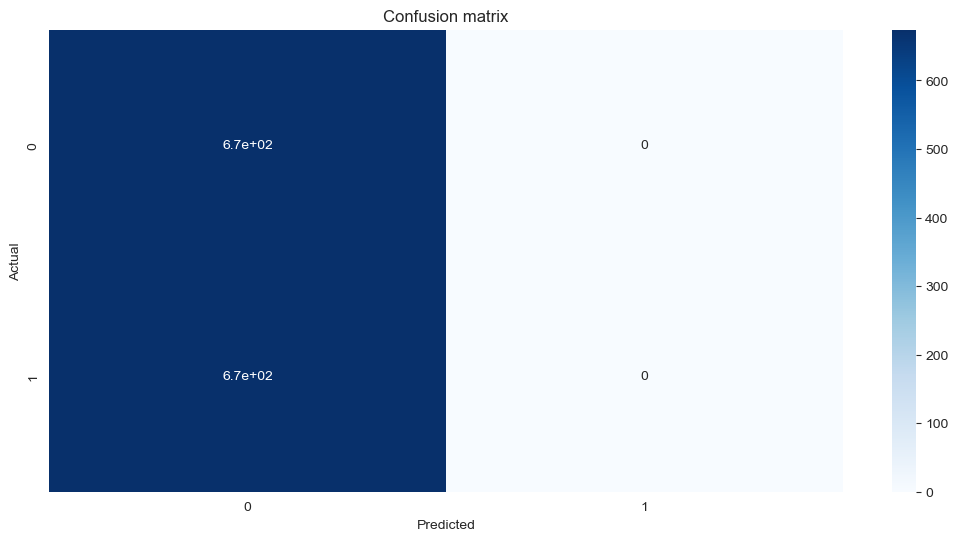

c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       674
           1     0.4996    1.0000    0.6663       673

    accuracy                         0.4996      1347
   macro avg     0.2498    0.5000    0.3332      1347
weighted avg     0.2496    0.4996    0.3329      1347



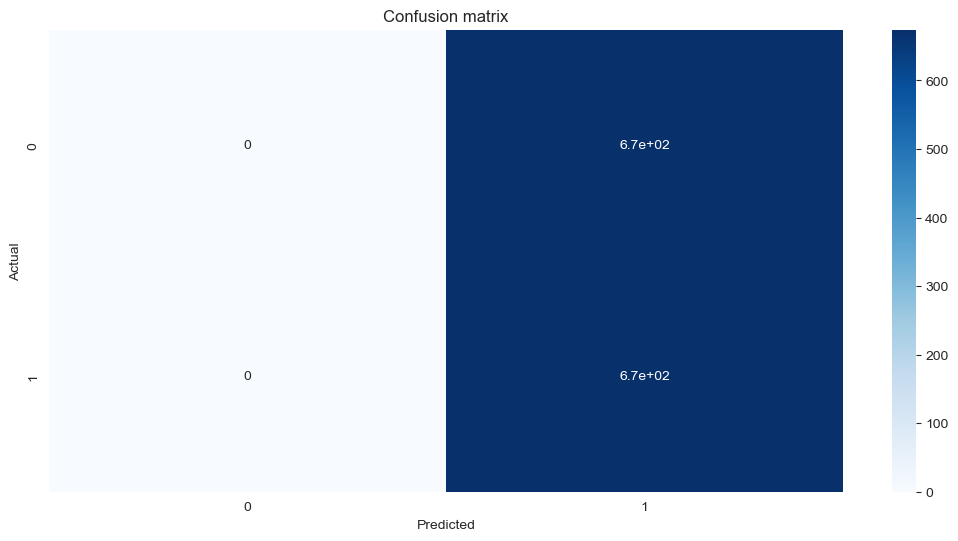

c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



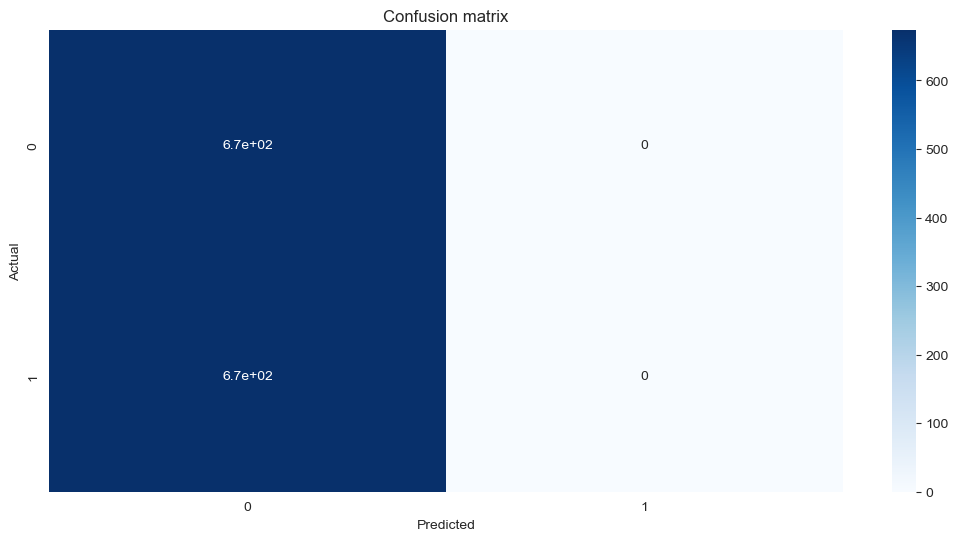

c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



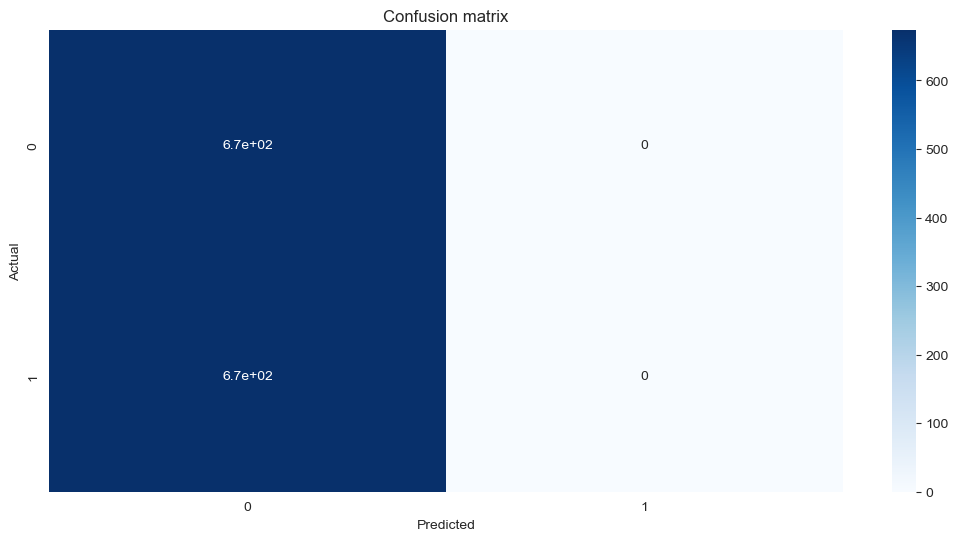

In [49]:
for pipe in Pipes:
    f1,acc = display_results(pd.DataFrame(y_val)[0],pipe.model.predict(pipe.processed_X_val))

In [50]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

In [51]:
pipe.processed_X_val[:, n : (n + w_length)]

array([[ 0.000097,  0.0001  ,  0.0001  , ...,  0.000028,  0.000033,
         0.000039],
       [ 0.000019,  0.000021,  0.000021, ...,  0.00002 ,  0.000007,
        -0.000001],
       [ 0.000059,  0.000052,  0.000053, ..., -0.000037, -0.000025,
        -0.000025],
       ...,
       [ 0.000027,  0.000025,  0.000075, ...,  0.000019,  0.000007,
         0.000015],
       [ 0.00002 ,  0.000013, -0.00002 , ...,  0.000014,  0.000003,
         0.000005],
       [ 0.000044,  0.000033,  0.000067, ..., -0.000008, -0.000003,
         0.000012]])

In [52]:
results_val["lda_pca12_channel_csp4"]

Pipeline(steps=[('model', LinearDiscriminantAnalysis())])

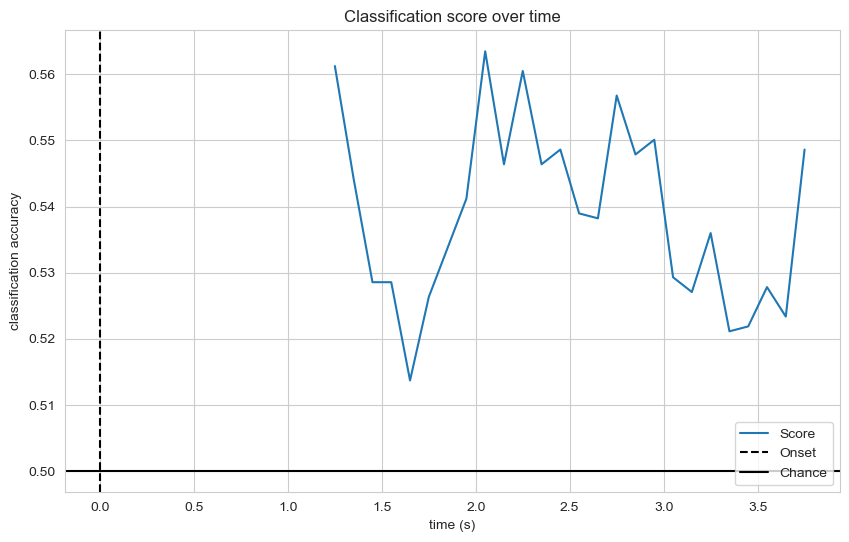

In [53]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data_train.shape[2] - w_length, w_step)

scores_windows = []


# running classifier: test classifier on sliding window
score_this_window = []
for n in w_start:
    transform_list = []
    for event in X_val[:, :, n : (n + w_length)]:
        transform_list.append(pca12_channel.transform(event.T))
    transform_list = np.stack(transform_list, axis=2) 
    X_val_windoed_csp15 = pca12_channel_csp15.transform(transform_list.T)
    score_this_window.append(results_val["lda_pca12_channel_csp15"].score(X_val_windoed_csp15, y_val))
scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs_train.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()